# Example Calculation
## Client: INTERNAL
---
## Project: Evaluation of an Air Source Heat Pump in Calgary
## Calc: CALC-001, heat pump
---
## Authentication
> Stamp, Permit
---
## Revision History
|Revision | Date | Description | By | Reviewer|
| :-------| :----|:------------|:---|:--------|
|       | | DRAFT | KCD |  |
|         |          |            |     |    |

---

## Objective

The traditional way (and simplest) to heat our homes in Alberta is with a gas fired furnace. However, this is not the only way. An Air Source Heat Pump (ASHP) is essentially a refrigeration unit that tries to cool off the outside air, and push the heat into the house. Heat pumps are fairly common in areas that do not have an extensive natural gas distribution, and are a bit warmer than Alberta.

Heat pumps have traditionally been limited to areas with mild winters (over 0 C). This is to prevent frost buildup on the unit.  However, there have been advances in defrosting techniques and Cold Climate Air Source Heat Pump (CCASHP) have been used sucessfully down to -25 C. You can find CCASHP units in Manitoba, and it gets pretty cold there.

The objective of this study is to determine if a cold climate air source heat pump (CC-ASHP) is effective in Calgary, in terms of a) cost, b) effective CO2 emissions.

How hard can this be?  I get the feeling we might end up shaving a yak [3].

![yak_shaving](yak.jpeg)



In [1]:
import numpy as np
import pandas as pd
import csv

import math as ma
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model

import scipy as sp
import copy
from scipy import interpolate



from sklearn.linear_model import LinearRegression

regressor = LinearRegression()




## Get COP data for the heat pump

I found some data for the COP (coefficient of performance) for air source heat pumps.

Data from Shen [1]
![hp_ref_1](heat_pump_performance.jpg)
This has two different data sets for the overall performance (including thaw cycles). The top one (green) shows high COP, but there is only data down to 17 F (-8 C). I don't know if this heat pump can operate at really low temperatures. The bottom two sets (black and fuscia) have a lower COP but the data extends down to -10 F (-23 C), which is applicable for most of the winter conditions in Calgary.

Data from an experimental heat pump [2] is available for a wide range of operating conditions (down to -13 F, or -25 C).
![hp_ref_2](newCCASHP_COP.jpg)

Plotting all data sets....

In [2]:
COP1 = pd.read_csv('heat_pump_performance.csv')
COP2 = pd.read_csv('heat_pump_performance2.csv')
COP = pd.read_csv('newCCASHP_COP.csv');
COP1['t_C'] = (COP1['t_F'] - 32.0)* 5.0/9.0;
COP2['t_C'] = (COP2['t_F'] - 32.0)* 5.0/9.0;
COP['t_C']  = (COP['t_F'] - 32.0)* 5.0/9.0;

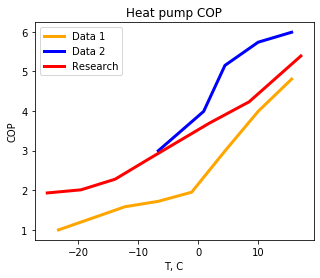

In [3]:
plt.figure(figsize=(5, 4))

plt.plot(COP1.t_C, COP1.COP, color='orange',linewidth=3,label='Data 1')
plt.plot(COP2.t_C, COP2.COP, color='blue',linewidth=3,label='Data 2')
plt.plot(COP.t_C, COP.COP, color='red',linewidth=3,label='Research')
plt.xlabel('T, C')
plt.ylabel('COP')
plt.title('Heat pump COP')
plt.legend()
plt.savefig('copCompare.png',dpi=300)

We will use the research data (red line) for estimating the COP as a function of ambient temperature.

This is nice, but the ambient temperature changes during the heating season.

## Heat required for house in winter months

The gas bill for my house is
<img src="gas_bill.png" style="width:200px;height:300px"/>

I also found the average outside temperature for these months (from Environment Canada).



In [4]:
# my fuel consumption data
fuelConsumptionTable = {'Month': ['September','October','November','December', 'January','February'],
                       'GJ': [3,13, 16, 19, 21, 27],
                       'ambientT': [13.2, 3.1, -0.2, -2.4, -4.2, -11.2]}
# there is a base load of 2 GJ per month that is not related to temperature.
fuelCons = pd.DataFrame(fuelConsumptionTable, columns = ['Month', 'GJ', 'ambientT'])
fuelCons

,Month,GJ,ambientT
0,September,3,13.2
1,October,13,3.1
2,November,16,-0.2
3,December,19,-2.4
4,January,21,-4.2
5,February,27,-11.2


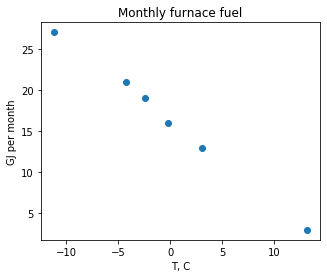

In [37]:
plt.figure(figsize=(5, 4))
plt.scatter(fuelCons['ambientT'],fuelCons['GJ'])
plt.xlabel('T, C')
plt.ylabel('GJ per month')
plt.title('Monthly furnace fuel')
plt.savefig('monthlyFuel.png',dpi=300)

This is fairly linear, as we expect.

Now create a simple linear model to relate heat demand as a function of ambient temperature. The data shows a minimum fuel demand of 2 GJ/month in the summer (no furnace heat needed). Also, I will assume that the house heat is 75% of the natural gas fuel value: this is the efficiency of my furnace.

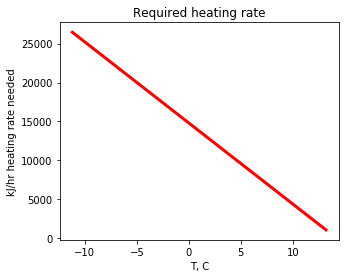

In [6]:
# Create linear regression object
regr = linear_model.LinearRegression()
X = fuelCons['ambientT'].values.reshape(-1,1)

# The data is in GJ per month and we want kJ per hour
# account for the 2 GJ/month offset in the summer
# and use 75% as fuel efficiency of my furnace
Y = 0.75*(fuelCons['GJ'].values - 2.0) *1000000/(30*24) 

# Train the model using the training sets
regr.fit(X, Y)

# Plot outputs
plt.figure(figsize=(5, 4))
plt.plot(X, regr.predict(X), color='red',linewidth=3)
plt.xlabel('T, C')
plt.ylabel('kJ/hr heating rate needed')
plt.title('Required heating rate')
plt.savefig('heatRate.png',dpi=300)

In [7]:
model = LinearRegression().fit(X, Y)
(model.intercept_, model.coef_)

(14809.736943751916, array([-1039.16372793]))

And we have a function to calculate the heat rate needed by the house (in kJ/hr) as a function of ambient temperature (in deg C).

Great, but this is for monthly averages, and we know the ambient temperature changes from hour to hour.

## Hourly data for ambient temperature

This is a yak all to itself. Environment Canada has historical data for many weather stations across Canada.  We want the station for Calgary International Airport because the hourly data goes back about 12 years.

Go to the Environment Canada site [4]:

https://climate.weather.gc.ca/historical_data/search_historic_data_e.html

Find the site you want. We could get data from here, but it would be tedious to get data one month at a time. Instead, copy the HTML address from the site and paste somewhere convenient. For the Calgary International Airport, we get the following HTML address

```
https://climate.weather.gc.ca/climate_data/hourly_data_e.html?hlyRange=2008-12-22%7C2021-10-09&dlyRange=1999-05-01%7C2021-10-09&mlyRange=2000-06-01%7C2007-11-01&StationID=27211&Prov=AB&urlExtension=_e.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2021&selRowPerPage=25&Line=5&searchMethod=contains&Month=10&Day=9&txtStationName=calgary&timeframe=1&Year=2021
```
The stationID is in this line of text.
```
StationID=27211
```
Now we edit a short piece of code to fetch a bunch of data from the command line. This code comes from Environment Canada, we only need to change the StationID variable.




In [ ]:
# fetching data from env canada
# this is a linux shell script, it runs OK from command line
StationID=27211
for year in `seq 2006 2021`;
    do for month in `seq 1 12`;
    do wget --content-disposition "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=${StationID}&Year=${year}&Month=${month}&Day=14&timeframe=1&submit= Download+Data" ;
    done;
done


Copy all of this code, paste into the command line and hit return.


That produces a bunch of files, one for each month, of weather data.

Combine all of the files into one large file
```
cat en_climate_*.csv > data.csv
```
Then we need to remove all of the header lines (144 of them). We will remove any lines containing Longitude.

```
grep -v -e Longitude data.csv > data2.csv
```

And we want the first line from the file data.csv because this contains the headers for the table.
```
head -n 1 data2.csv > header.csv
```
and then concatenate the header with the bulk of the data table
```
cat header.csv data2.csv > calgaryWeather2.csv
```
We might be able to do all of this using Python, inside the Jupyter Notebook, but I don't know how.

Now we have 12 years of hourly data for Calgary International Airport (Station ID 27211). Then I created 30 bins for the ambient temperature and determined the number of hours in each bin.

In [30]:
# lets get the ambient temperature data
weatherData = pd.read_csv('calgaryWeather2.csv');

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (12,14,16,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
weatherData.head()

,Longitude,Latitude,StationName,ClimateID,DateTime,Year,Month,Day,Time,TempC,...,StnPressFlag,Hmdx,HmdxFlag,WindChill,Wind ChillFlag,Weather,realTempC,intMonth,tempBins2,bin_centres
0,-114.0,51.11,CALGARY INT'L CS,3031094,2010-01-01 00:00,2010,1,1,00:00,-21.6,...,NaN,NaN,NaN,NaN,NaN,NaN,-21.6,1,"(-23.213, -20.917]",-22.0650
1,-114.0,51.11,CALGARY INT'L CS,3031094,2010-01-01 01:00,2010,1,1,01:00,-21.2,...,NaN,NaN,NaN,NaN,NaN,NaN,-21.2,1,"(-23.213, -20.917]",-22.0650
2,-114.0,51.11,CALGARY INT'L CS,3031094,2010-01-01 02:00,2010,1,1,02:00,-20.8,...,NaN,NaN,NaN,NaN,NaN,NaN,-20.8,1,"(-20.917, -18.62]",-19.7685
3,-114.0,51.11,CALGARY INT'L CS,3031094,2010-01-01 03:00,2010,1,1,03:00,-20.4,...,NaN,NaN,NaN,NaN,NaN,NaN,-20.4,1,"(-20.917, -18.62]",-19.7685
4,-114.0,51.11,CALGARY INT'L CS,3031094,2010-01-01 04:00,2010,1,1,04:00,-20.4,...,NaN,NaN,NaN,NaN,NaN,NaN,-20.4,1,"(-20.917, -18.62]",-19.7685


In [10]:
weatherData['realTempC'] = weatherData['TempC'].astype(float)
weatherData['intMonth'] = weatherData['Month'].astype(int)
weatherData['tempBins2']= pd.cut(weatherData['realTempC'], bins=30)

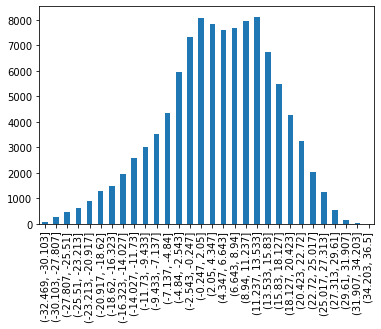

In [11]:
histoPlot=weatherData['tempBins2'].value_counts(sort=False).plot.bar()
plt.savefig('calgaryHisto.png',dpi=300)

The temperature distribution is bimodal, with one peak near 1 C, and the other peak near 12 C. This may illustrate the frequency of chinooks in Calgary.

The temperature at the midpoint of each bin is needed for modeling work.

In [12]:
weatherData["bin_centres"] = weatherData["tempBins2"].apply(lambda x: x.mid);

Now, normalize the data to determine the number of hours where the ambient temperature falls in each bin.

In [13]:
mybin = weatherData['bin_centres'].value_counts(sort=False, normalize=True)*365*24
mybin.head()

-31.2860     6.865597
-28.9550    22.438782
-26.6585    36.756064
-24.3615    50.905893
-22.0650    74.768031
Name: bin_centres, dtype: float64

Now we have the number of hours that we can expect to see the temperature as it falls in a given bin. We expect to see a temperature between -30.1 to -32.5 C about 6.9 hours per year. We see temperatures below -25 C about 65 hours per year.

It is time to compile the data for our task. We will start with the ambient temperature bins and the number of hours for each bin.

In [14]:
# weatherData['bin_centres'].unique()
# lets create dataframes for results
ambientT = weatherData['bin_centres'].unique()
homeHeat = pd.DataFrame(np.array(list(ambientT.value_counts().index)), columns = ['t_C'])
homeHeat['designHours'] = np.array(list(mybin))
homeHeat.head()

,t_C,designHours
0,-31.2860,6.865597
1,-28.9550,22.438782
2,-26.6585,36.756064
3,-24.3615,50.905893
4,-22.0650,74.768031


Excellent, but we need the heat rate for each of the temperature bins.

## Heat rate for each temperature bin

Now we can determine the heat rate needed for each of the temperature bins.

In [15]:
ambientT = weatherData['bin_centres'].unique()
#designX = list(ambientT.value_counts().index)
designX = np.array(list(ambientT.value_counts().index))
designHeat = model.predict(designX.reshape(-1,1))
homeHeat['designHeatRate'] = designHeat
homeHeat.head()


,t_C,designHours,designHeatRate
0,-31.2860,6.865597,47321.013336
1,-28.9550,22.438782,44898.722686
2,-26.6585,36.756064,42512.283185
3,-24.3615,50.905893,40125.324102
4,-22.0650,74.768031,37738.884601


Nice, but we need the total amount of heat (kJ) for each of these bins, not the heat rate.

## Heat for each temperature bin

We already have the number of hours for each temperature bin. We can multiply the heat rate by the number of hours to get the amount of heat needed for each temperature bin.

In [16]:
homeHeat['designHeat'] = homeHeat['designHours'] * homeHeat['designHeatRate']
homeHeat.head()

,t_C,designHours,designHeatRate,designHeat
0,-31.2860,6.865597,47321.013336,3.248870e+05
1,-28.9550,22.438782,44898.722686,1.007473e+06
2,-26.6585,36.756064,42512.283185,1.562584e+06
3,-24.3615,50.905893,40125.324102,2.042615e+06
4,-22.0650,74.768031,37738.884601,2.821662e+06


Now we need to find the amount of electrical energy needed to move this much heat (for each of the temperature bins).

## Determining the COP for each of the temperature bins
We will use the graph of COP vs temperature to look up the COP for each of the temperature bins. Divide the amount of heat needed for each bin by the corresponding COP and we get the amount of electrical energy needed for each temperature bin.

In [17]:
# get the COP for each of the temperature bins
interpType = 'linear'
homeHeat['heatpumpCOP'] = interpolate.interp1d(COP['t_C'], COP['COP'],  kind=interpType, bounds_error = False, fill_value="extrapolate", )(designX)
homeHeat['heatpumpElec'] = homeHeat['designHeat'] / homeHeat['heatpumpCOP']

homeHeat.head()


,t_C,designHours,designHeatRate,designHeat,heatpumpCOP,heatpumpElec
0,-31.2860,6.865597,47321.013336,3.248870e+05,1.843021,1.762796e+05
1,-28.9550,22.438782,44898.722686,1.007473e+06,1.875765,5.370996e+05
2,-26.6585,36.756064,42512.283185,1.562584e+06,1.908024,8.189541e+05
3,-24.3615,50.905893,40125.324102,2.042615e+06,1.940290,1.052737e+06
4,-22.0650,74.768031,37738.884601,2.821662e+06,1.972550,1.430464e+06


We are getting closer, but we need the cost of the electrical power and the amount of natural gas needed to generate the power with a combined cycle gas turbine (CCGT).

## Cost of energy

Since we are comparing the same fuel (methane) for heating our home with a furnace or driving a CCGT, we can compare only the amount of energy (kJ or GJ) associated with the fuel, either burned in a furnace use used to drive a CCGT.

But since we are interested in the amount of CO2 associated with heating our home, we will determine the CO2 intensity for natural gas (methane).


In [18]:
# get the CO2 intensity for burning methane
fuelHHV = 55385.0 # kJ/kg, HHV
ch4IntensityCO2 = 44.0/16.0 # one mole of CH4 produces one mole CO2
fuelCO2Intensity = ch4IntensityCO2 / fuelHHV
fuelCO2Intensity # kg CO2 per kJ
# or about 50 kg per GJ

4.965243296921549e-05

In [19]:
# we need the fuel needed to produce 1 kJ of electricity from a CCGT.
# Assume this is what provides our electricity
CCGTHeatRate = 7649.0              # BTU per kW.hr from NatGas
copCCGT      = CCGTHeatRate * 1.0550559 / 3600.0   # BTU / (kJ/s . hr) * 1.055e3 kJ/MMBTU * 1 hr / 3600 sec
copFurnace   = 0.9                 # 90% efficient furnace
copCCGT  # this is kJ of natural gas fuel per kJ of electricity


2.2417007164166667

And we also need natural gas prices. These are taken straight from my fuel bill, and consider all of the charges that are pro-rated by GJ of gas useage.

In [20]:
fuelPrice = ((193.65-8.52)/(11.86+9.21))  # $ per GJ, and this is equivalent to about 0.03 $ per kW.hr
# wholesale gas price is about 3.5$ per GJ for this point in time

# and we will have electricity price in $ per GJ
# $ per (kJ/s . hr) * 1 hr / 3600 sec * 1e6 kJ/1 GJ
elecPrice = (1e6/3600.0) * (217.46 - 20.97 - 7.48 - 6.92)/(941.7+346.3) # total utility bill less local access fee, admin charge rate riders
fuelPrice, elecPrice # Dollars per GJ, this is about right. 

(8.78642619838633, 39.2706176673568)

Electricity is about 4.5 times more expensive than natural gas on an energy basis. This difference in cost reflects the efficiency of producing electricity from natural gas (about 40% for a CCGT) and the payment of the capital needed to produce the power.

Electricity is much more expensive than natural gas. Things are not looking good for the financial justification of an air source heat pump in Calgary.

In [21]:
# lets create dataframes for results

homeHeat['heatpumpGasFuel'] = homeHeat['heatpumpElec'] * copCCGT
homeHeat['furnaceFuel']     = homeHeat['designHeat'] / copFurnace
homeHeat['heatpumpElecCost']= homeHeat['heatpumpElec'] * elecPrice / 1e6
homeHeat['furnaceFuelCost'] = homeHeat['furnaceFuel'] * fuelPrice / 1e6

Now we need to apply these cost values. We will drop the temperature bins that do not require heat.

In [22]:
# drop the rows where we do not need heat
homeHeat.drop(homeHeat[homeHeat.designHeatRate < 0.0].index, inplace=True)
homeHeat.head()

,t_C,designHours,designHeatRate,designHeat,heatpumpCOP,heatpumpElec,heatpumpGasFuel,furnaceFuel,heatpumpElecCost,furnaceFuelCost
0,-31.2860,6.865597,47321.013336,3.248870e+05,1.843021,1.762796e+05,3.951661e+05,3.609856e+05,6.922609,3.171773
1,-28.9550,22.438782,44898.722686,1.007473e+06,1.875765,5.370996e+05,1.204017e+06,1.119414e+06,21.092234,9.835649
2,-26.6585,36.756064,42512.283185,1.562584e+06,1.908024,8.189541e+05,1.835850e+06,1.736205e+06,32.160834,15.255034
3,-24.3615,50.905893,40125.324102,2.042615e+06,1.940290,1.052737e+06,2.359921e+06,2.269573e+06,41.341633,19.941433
4,-22.0650,74.768031,37738.884601,2.821662e+06,1.972550,1.430464e+06,3.206673e+06,3.135180e+06,56.175224,27.547029


I think we are almost done with this yak.

## Checking results

First we will look at the amount of energy needed to keep our house warm, and which temperature consumes the majority of the heat.

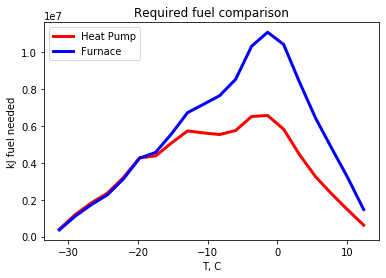

In [23]:
plt.plot(homeHeat.t_C, homeHeat['heatpumpGasFuel'], color='red',linewidth=3, label='Heat Pump')
plt.plot(homeHeat.t_C, homeHeat['furnaceFuel'],     color='blue',linewidth=3, label='Furnace')
plt.xlabel('T, C')
plt.ylabel('kJ fuel needed')
plt.title('Required fuel comparison')
plt.legend()
plt.savefig('fuelCompare.png',dpi=300)

In Calgary, most of our heat is needed between 5 and -15 C, seen with the blue line for the furnace fuel requirement.

The heat pump is quite efficient at -5 C. At this temperature, the CCGT needs about half of the natural gas fuel to create the electricity that drives the heat pump. 

The fuel benefit for the heat pump drops to nothing as the temperature drops to -15 C.

What about cost?

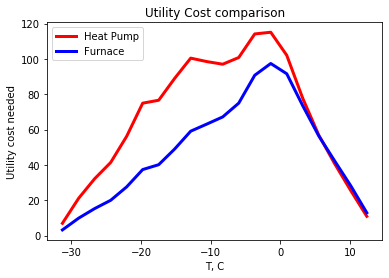

In [24]:
plt.plot(homeHeat.t_C, homeHeat['heatpumpElecCost'], color='red',linewidth=3, label='Heat Pump')
plt.plot(homeHeat.t_C, homeHeat['furnaceFuelCost'],  color='blue',linewidth=3, label='Furnace')
plt.xlabel('T, C')
plt.ylabel('Utility cost needed')
plt.title('Utility Cost comparison')
plt.legend()
plt.savefig('costCompare.png',dpi=300)

The air source heat pump is more expensive to run than a natural gas furnace. Where the gas furnace has a clear maximum cost for temperatures between -5 to 2 C, the heat pump has a broader region of high operating costs, from -15 to 2 C. While the number of hours drops off at temperatures lower than -5 C, the heat pump becomes less effective. 

It is useful to look at temperature range that represents the majority of our heating requirements.

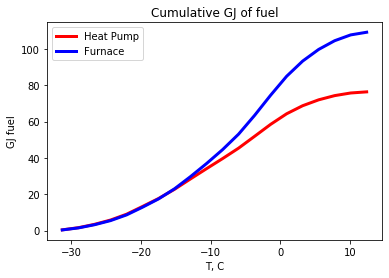

In [25]:
plt.plot(homeHeat.t_C, homeHeat['heatpumpGasFuel'].cumsum()/1e6, color='red',linewidth=3,label='Heat Pump')
plt.plot(homeHeat.t_C, homeHeat['furnaceFuel'].cumsum()/1e6,     color='blue',linewidth=3,label='Furnace')
plt.xlabel('T, C')
plt.ylabel('GJ fuel')
plt.title('Cumulative GJ of fuel')
plt.legend()
plt.savefig('CUMenergyCompare.png',dpi=300)

In [35]:
(homeHeat['heatpumpGasFuel'].sum()*fuelCO2Intensity,
homeHeat['furnaceFuel'].sum()*fuelCO2Intensity,
 'kg/yr CO2 emissions for heat pump and furnace')

(3790.0375989612353,
 5418.996715989588,
 'kg/yr CO2 emissions for heat pump and furnace')

The amount of natural gas energy needed for the gas furnace or the electrical power to drive the heat pump is identical below -15 C. Above -10 C the efficiency of the heat pump over the gas furnace is clear.

Over the entire heating season, the heat pump is associated with a 30% reducion in CO2 emissions (from the CCGT power plant) compared to the CO2 emissions from the gas furnace .

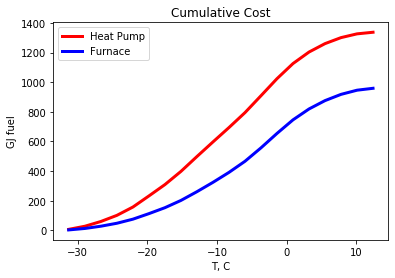

In [27]:
plt.plot(homeHeat.t_C, homeHeat['heatpumpElecCost'].cumsum(), color='red',linewidth=3, label='Heat Pump')
plt.plot(homeHeat.t_C, homeHeat['furnaceFuelCost'].cumsum(),  color='blue',linewidth=3, label='Furnace')
plt.xlabel('T, C')
plt.ylabel('GJ fuel')
plt.title('Cumulative Cost')
plt.legend()
plt.savefig('CUMcostCompare.png',dpi=300)


In [28]:
homeHeat['heatpumpElecCost'].sum(), homeHeat['furnaceFuelCost'].sum()

(1337.189895319742, 958.9382003468155)

Cost tells a different story. The heat pump is always more expensive to operate than a natural gas furnace.

Over the heating season, the heat pump is 40% more expensive to operate (in fuel cost) than the natural gas furnace.

## After thoughts
I did not expect an air source heat pump to be a viable option for Calgary, in terms of overall fuel consumption (CO2 emissions) or cost. I was surprised by the result.

Even though Alberta produces electricity by burning natural gas in a CCGT, and Calgary winters are a bit cold, the cold climate air source heat pump should yield a 30% savings on CO2 emissions over an efficient natural gas furnace. I suspect the gas furnace is still needed on those infrequent hours where the air temperature is below -25 C. 

But the gas furnace still wins (in Calgary) in terms of utility cost. As well, installing a gas furnace is less expensive than installing a heat pump.

The results depend on the ambient temperature. Edmonton has colder winters than Calgary. I expect the furnace to be the winner in terms of both CO2 emissions and fuel cost in Edmonton.

However, people living near warmer cities such as Lethbridge and Medicine Hat may find that a cold climate heat pump is cost effective, and offers a significant reduction in CO2 emissions.

Happy yak shaving.

## References
1. Shen, High Efficiency Cold Climate Heat Pump, 2017 Building Technologies Office Peer Review (2017)
2. Tom Marsik and others, Air Source Heat Pumps in Cold Climates, NREL, CCHRC (slide 9) (2018)
3. Yak shaving, https://americanexpress.io/yak-shaving/
4. Environment Canada Historical Climate Data, https://climate.weather.gc.ca/historical_data/search_historic_data_e.html